# On the Validation of UMAP


There is not a large body of _practical_ work on validating [Uniform Manifold Approximation and Projection UMAP](https://arxiv.org/abs/1802.03426). In this blog post, I will show you a real example, in hopes to provide an additional method for validating the algorithm's results.

In general, a common practice is to validate UMAP's convergence based on a downstream task. For example, in the case of classification, you use an objective metric such as [F1-Score](https://en.wikipedia.org/wiki/F-score) to confirm that the dimensionality reduction technique captured the underlying data structure. However, a high F1-Score **does not assure** that UMAP accurately captured the data's structure. High accuracy on the downstream task just tells you that the data is separable at lower-dimension, performing well given it's inputs.

Simply put, use both a measure to evaluate the underlying data’s structure retention **and** a downstream task measure.  Trustworthiness and Continuity does the former.

This blog post will walk you through how to run Trustworthiness and Continuity as an extra check using the DenseClus package to confirm that UMAP converged into a stable result.

## Before that, What is UMAP?

UMAP is a non-linear dimensionality reduction technique for high dimensional data. Visually similar to the t-SNE algorithm (also eclipsing it),  UMAP takes in the assumption that the data is uniformly distributed on a [locally connected](https://en.wikipedia.org/wiki/Locally_connected) [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold) and that the [Riemannian metric](https://en.wikipedia.org/wiki/Riemannian_metric) is locally constant or approximately locally constant (see: [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction — umap 0.3 documentation"](https://umap-learn.readthedocs.io/en/latest/))

In the [UMAP paper](https://arxiv.org/abs/1802.03426) (UMAP: Uniform Manifold Approximation and Projection McInnes et al 2018), there are proofs that require a PHD in Topology to fully comprehend.

For now, let’s define it as a **neighbor-based** dimensionality reduction method that can handle numeric and/or categorical data.

If you desire a deeper level of understanding, check out the UMAP documentation link above or one of the PyData talks by the authors.

## Fitting a UMAP

At any rate, let's grab some data to work with.

You'll grab a data from the [Churn Pipeline](https://github.com/awslabs/aws-customer-churn-pipeline) repo directly the to run the example.

The original churn dataset is publicly available and mentioned in the book [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/). It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.


In [5]:
%pip install --upgrade jupyter -q
%pip install --upgrade ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# To supress deprecation warnings
import logging
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from umap import validation

from denseclus import DenseClus

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url).sample(n=2000, random_state=SEED)
df.drop(["Phone", "Area Code"], axis=1, inplace=True)

Next, now that a dataset it is loaded, let's fit Amazon [DenseClus](https://github.com/awslabs/amazon-denseclus) to it.
Underneath the hood DenseClus runs UMAP and [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) to fit coherent groups to mixed type data [Read more about it in this blog post here](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/).

In essence, the below code fits two UMAP layers one for the numeric data and one for the categorical data, and then combines the two. For the most part, the preprocessing steps are taken care under the hood.

In [7]:
logging.captureWarnings(True)

hdbscan_params = {"cluster_selection_method": "leaf"}

clf = DenseClus(
    random_state=SEED,
    hdbscan_params =hdbscan_params ,
    umap_combine_method="intersection_union_mapper"
)

clf.fit(df)

logging.captureWarnings(False)

Max of 51 is greater than threshold 25
Hashing categorical features


Please note that, you are setting a seed here for reproducibility, this means UMAP is going to run on a single core. In the real world, you will not run on a single core. This means that real world results will vary between runs due to the algorithms stochastic nature.


In [8]:
clf.numerical_umap_.embedding_

array([[3.8573391, 7.4530907, 6.9856286, 6.4291935, 4.668752 ],
       [4.5546823, 6.836398 , 9.664777 , 5.0840516, 6.3669257],
       [5.512423 , 6.306098 , 9.828715 , 5.108828 , 6.5268445],
       ...,
       [4.495967 , 7.753233 , 7.06778  , 6.599093 , 4.713311 ],
       [4.2505097, 5.9391913, 9.287599 , 5.051394 , 6.819037 ],
       [4.91854  , 5.8084493, 9.534951 , 5.469249 , 6.5120883]],
      dtype=float32)

##  Trustworthiness Works

Trustworthiness and Continuity measure how well a data’s structure is preserved after dimensionality reduction. 

Here, the distance of point *i* in high-dimensional space is measured against its k closest neighbours using rank order, and the extent to which each rank changes in low-dimensional space is measured. For n samples, let r(i,j) be the rank in distance of sample i to sample j in the high-dimensional space Uki. Similarly, let rˆ(i,j) be the rank of the distance between sample i and sample j in low-dimensional space Vki. Using the k-nearest neighbours, the map is considered trustworthy if these k neighbours are also placed close to point i in the low-dimensional space.

Similarly, continuity measures the extent to which original clusters of datapoints are preserved, and can be considered the inverse to trustworthiness, finding sample points that are close to point i in low-dimensional space, but not in the high-dimensional plane.

Scores for each calculations are output between 0 and 1. The higher the score, the more the local structure of the original dataset is retained in the UMAP embeddings.

UMAP has a Numba optimized calculation  (under the validation sub-module) that will scale well to medium sized data.
As noted [here](https://github.com/lmcinnes/umap/issues/6), another reference is in the [SKLearn library](https://github.com/scikit-learn/scikit-learn/blob/ccd3331f7eb3468ac96222dc5350e58c58ccba20/sklearn/manifold/t_sne.py#L394).

Just like the above, the pairwise distance at point K is taken between the original data and the embedding. If any unexpected neighbors are found they are penalized in proportion to their rank based on the original data 

Enough of that, let's check that the embedding captured its neighbors in the underlying data.

## Running Validation on the Data

For this example you will set K=50, looking at 50 neighboring points for comparison.

*Note: you are using the default euclidean distance calculation here but keep in mind that this is supported for alternative pari-wise or squared distances. Ultimately, this is a problem specific choice.*


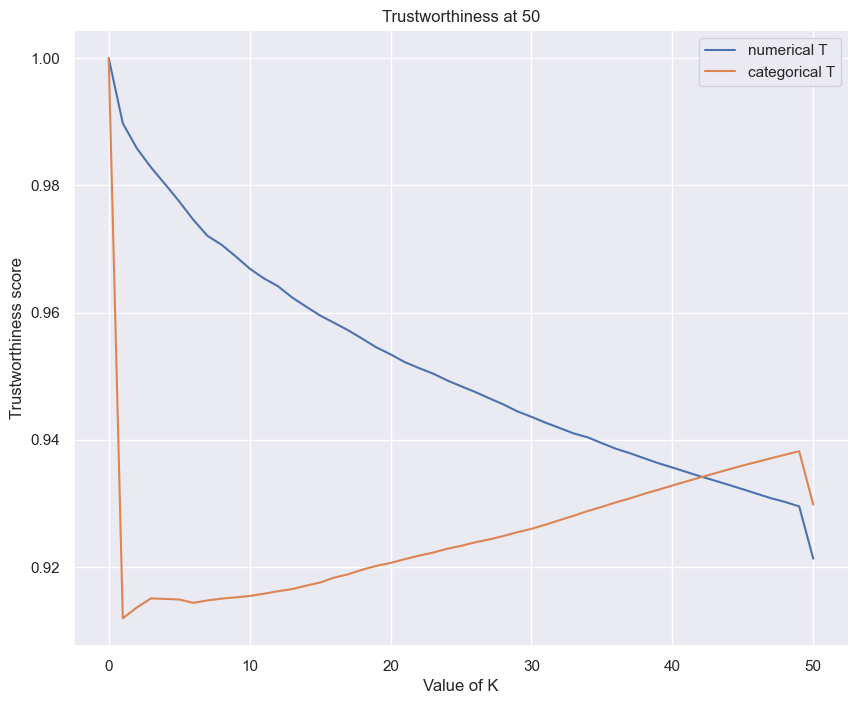

In [11]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


_ = plt.plot(numerical_trustworthiness)
_ = plt.plot(categorical_trustworthiness)
_ = plt.ylabel("Trustworthiness score")
_ = plt.xlabel("Value of K")
_ = plt.title(f"Trustworthiness at {K}")
# _=plt.ylim(0,1)
_ = plt.legend(["numerical T", "categorical T"], loc="upper right")

Generally speaking, a score above 0.80 is considered to be a **“good”** result.
A lower score indicates that you need to look at input data and the UMAP parameters to find a better fit.

DenseClus defaults at using K=30 for neighbors to generate the UMAP embeddings so this is fair comparison to make.

## Conclusion

In this blog post you learned how to to validate UMAP embeddings by using Trustworthiness to look at how far away neighboring points fall between the the source data and the embeddings.

[DenseClus](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/) provided an easy way to demonstrate validating multiple embeddings in this way. Believe it or not, DenseClus combines the two into a third embedding space to compute clusters! However, this space does not have input data to compare as it is created via set operations between the UMAP graphs. The best way to further validate success here is by proceeding to running on a downstream task.

In the next blog post, I will cover just this.

If you got this far, thanks for reading :)

Keep in mind that you've only scratched the surface here. It's possible to tune the multiple underlying hyperparameters available based on the downstream task method with Trustworthiness as a constraint.

The notebook for this examples is posted under DenseClus's Github repo [here](https://github.com/awslabs/amazon-denseclus/tree/main/notebooks/Validating_UMAP_Example.ipynb).

### References

*"Uniform manifold approximation and projection for dimension reduction"*, McInnes, Leland; Healy, John; Melville, James 2018

*“Neighborhood Preservation in Nonlinear Projection Methods: An Experimental Study”*, Venna 2001

*“Semantically Controlled Adaptive Equalisation in Reduced Dimensionality Parameter Space“*, Stasis et al 2016